In [1]:
import sys, os
import sparse
import xsimlab as xs
import numpy as np
import pandas as pd
import igraph as ig
from pgljupyter import SceneWidget

In [2]:
sys.path.insert(0, os.path.join(os.getcwd(), '..'))
import vmlab
from vmlab.models.vmango import vmango as model
from vmlab.enums import Nature, Position

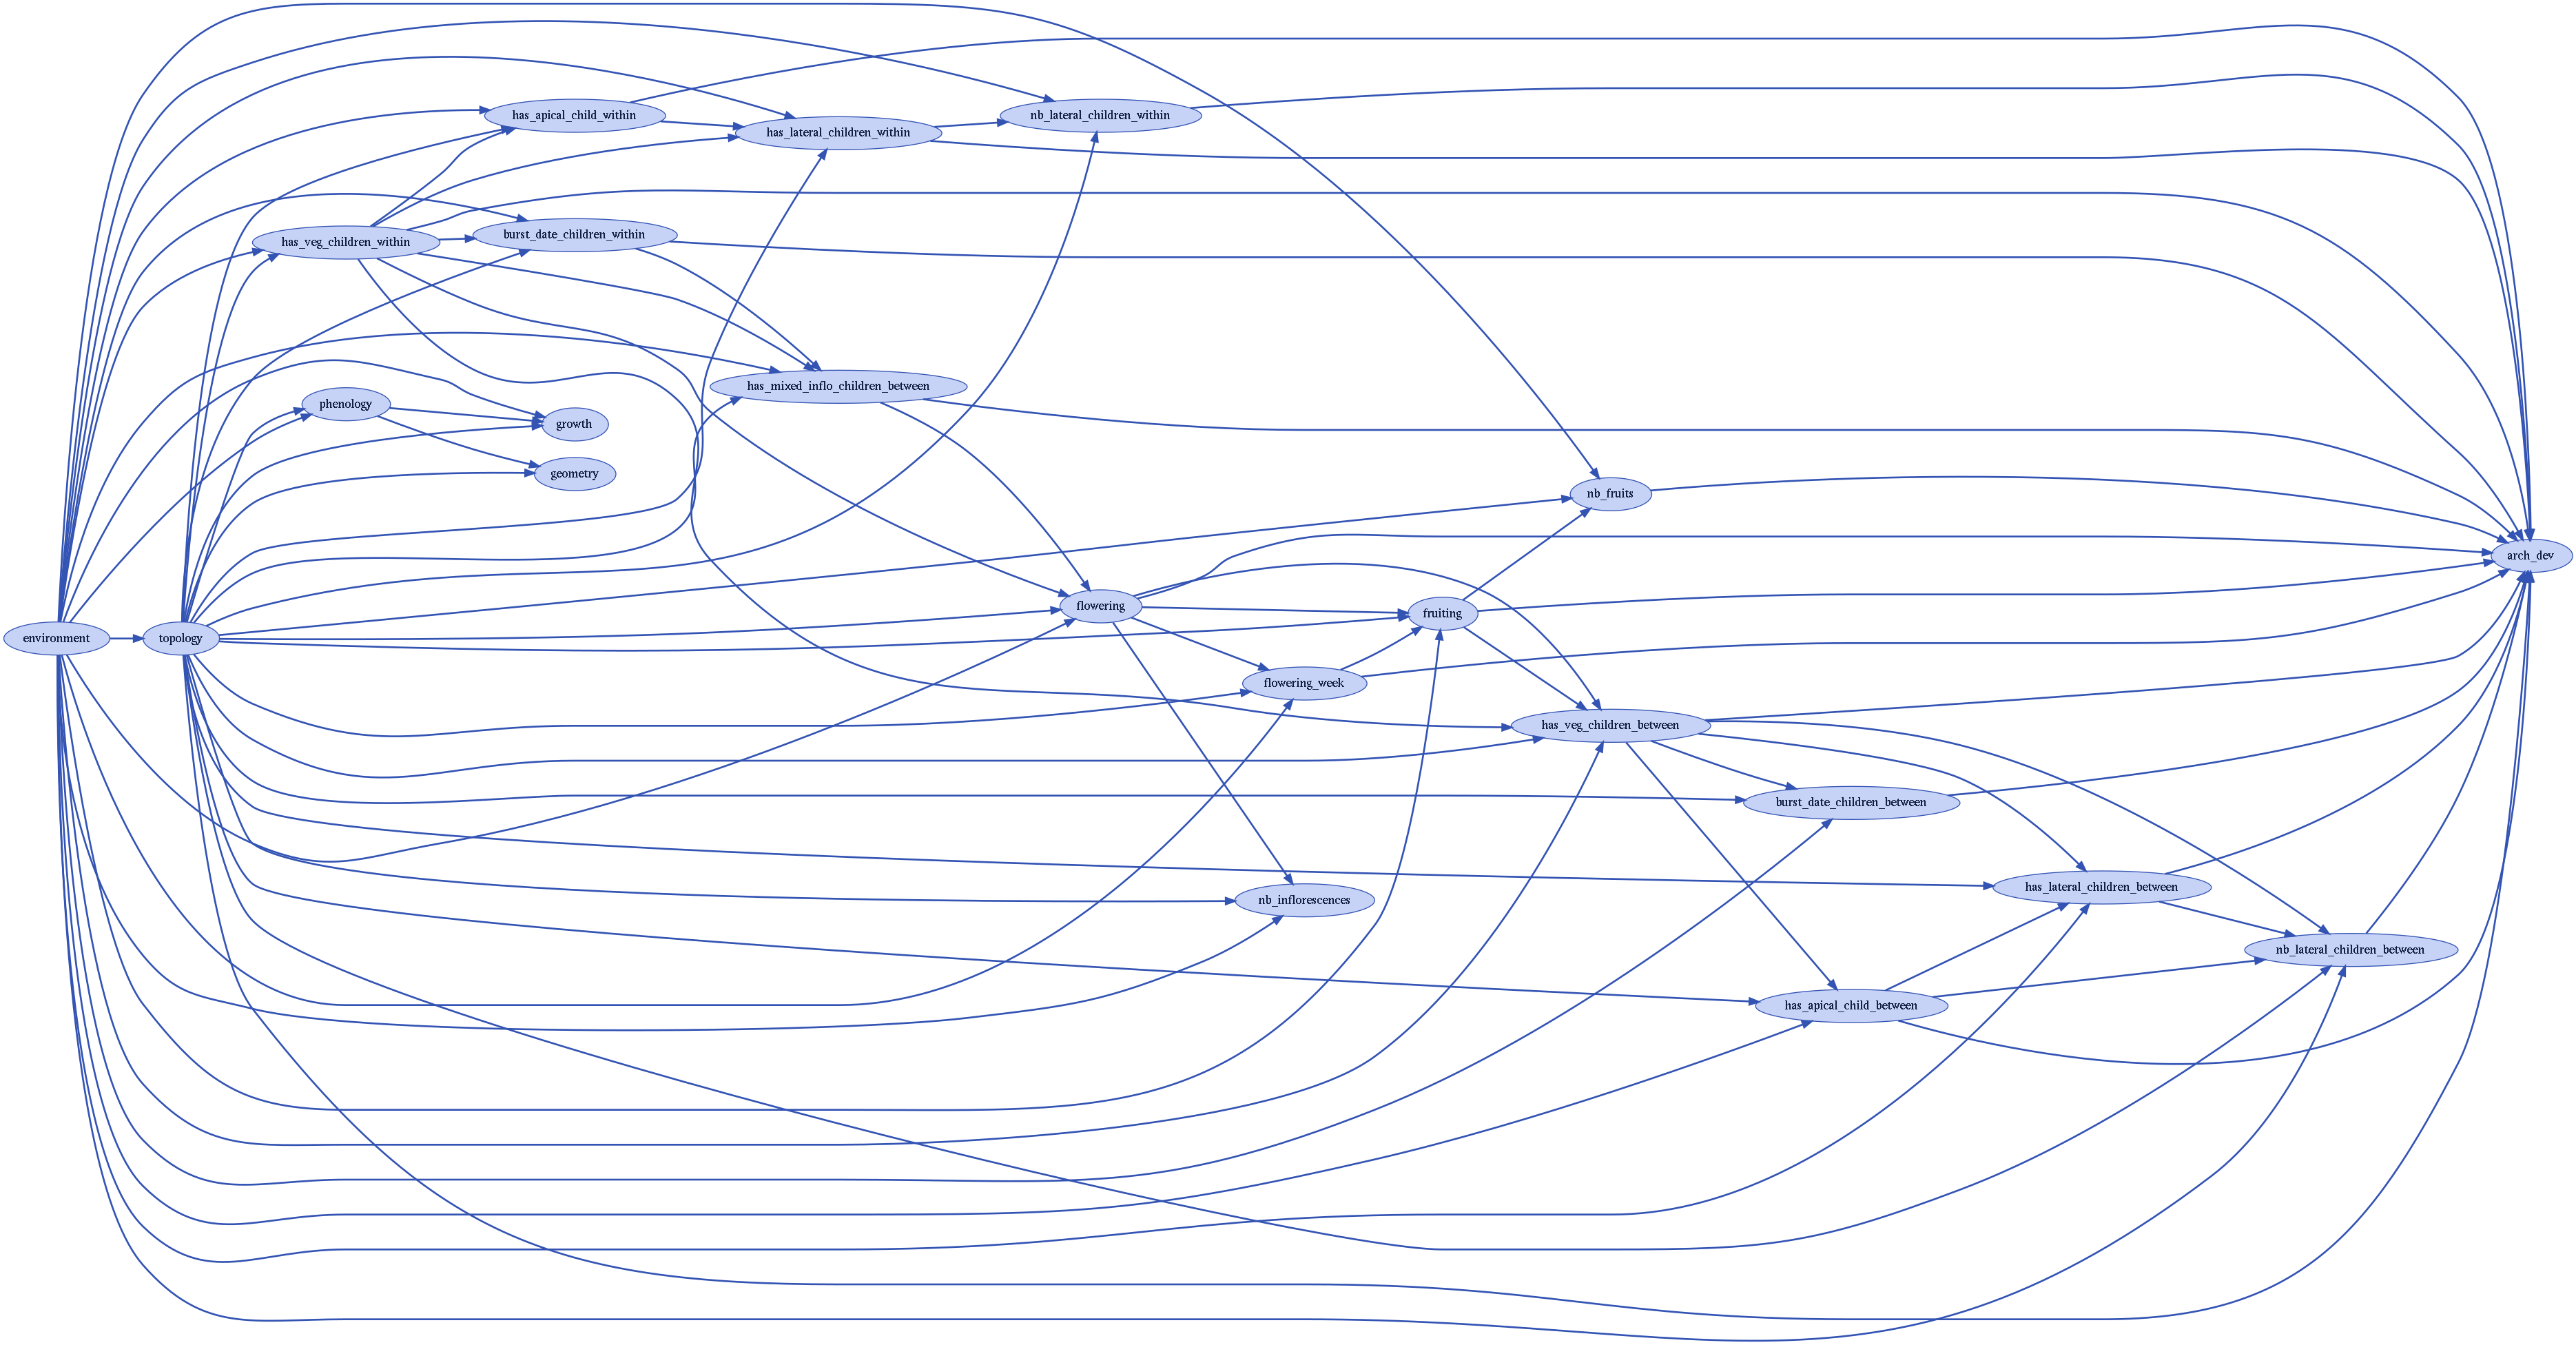

In [3]:
model.visualize()

In [4]:
nb_gus = 4
g = ig.Graph.Tree(nb_gus, 3, mode=ig.TREE_OUT)
adjacency = np.array(g.get_adjacency().data)

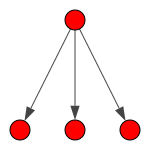

In [5]:
ig.plot(g, bbox=(0,0,150,150), layout=g.layout_reingold_tilford())

In [6]:
final_length_internodes = np.array([None, None, None, None], dtype=np.object)
final_length_internodes[0] = [10]
final_length_internodes[1] = [10]
final_length_internodes[2] = [10]
final_length_internodes[3] = [10]
ds = vmlab.create_setup(
    model=model,
    setup_toml='../share/setup/vmango.toml',
    clocks={
        'day': pd.date_range(start='2002-05-01', end='2005-05-01', freq="1d")
    },
    main_clock='day',
    input_vars={
        'topology': {
            'current_cycle': 3,
            'month_begin_veg_cycle': 7,
            'doy_begin_flowering': 214,
            'adjacency': adjacency,
            'position': np.array([Position.APICAL, Position.LATERAL, Position.LATERAL, Position.APICAL])
        },
        'phenology': {
            'bloom_date': np.full(nb_gus, '2002-11-01')
        },
        'arch_dev': {
            'burst_date': np.array(['2002-04-01', '2002-06-01', '2002-06-01', '2002-06-01'], dtype='datetime64[D]'),
            'has_apical_child': np.ones(nb_gus),
            'nb_lateral_children': np.full(nb_gus, 2),
            'nature': np.full(nb_gus, Nature.VEGETATIVE)
        },
        'growth': {
            'final_length_internodes': final_length_internodes,
            'radius_gu': np.ones(nb_gus),
            'nb_internode': np.ones(nb_gus),
            'length_gu': np.ones(nb_gus),
            'final_length_gu': np.ones(nb_gus),
            'final_length_leaves': np.array([None, None, None, None], dtype=np.object),
            'length_leaves': np.array([None, None, None, None], dtype=np.object),
            'final_length_inflo': np.array([None, None, None, None], dtype=np.object),
            'length_inflo': np.array([None, None, None, None], dtype=np.object)
        },
        'flowering_week': {
            'flowering_date': np.full(nb_gus, np.datetime64('NAT'), dtype='datetime64[D]')
        },
        'nb_inflorescences': {
            'nb_inflorescences': np.zeros(nb_gus)
        }
    },
    output_vars=None
)

In [7]:
sw = SceneWidget(size_world=2.5)
sw

SceneWidget(scenes=[{'id': 'M3Cw2M6NRWnZIQKqJpLCANtdK', 'data': b'x\xdaSLrw\xf5\xf7e`Pp\xe0\xe5RPVVd\x00\x020\…

In [8]:
@xs.runtime_hook(stage='run_step')
def hook(model, context, state):
    if context['step'] % 1 == 0:
        scene = state[('geometry', 'scene')]
        sw.set_scenes([scene], scales=[1/100])
    
ds_out = ds.xsimlab.run(model=model, decoding={ 'mask_and_scale': False }, hooks=[xs.monitoring.ProgressBar(), hook])
ds_out

             0% | initialize 

<string>:125: RuntimeWarning: invalid value encountered in double_scalars


<xarray.Dataset>
Dimensions:                                                             (GU: 78, day: 1097, hour: 24)
Coordinates:
  * GU                                                                  (GU) <U10 ...
  * day                                                                 (day) datetime64[ns] ...
  * hour                                                                (hour) int8 ...
Data variables:
    arch_dev__burst_date                                                (GU) datetime64[D] ...
    arch_dev__has_apical_child                                          (GU) float64 ...
    arch_dev__nature                                                    (GU) float64 ...
    arch_dev__nb_lateral_children                                       (GU) int64 ...
    burst_date_children_between__burst_date_children_between            (GU) datetime64[D] ...
    burst_date_children_between__table_dir_path                         <U80 ...
    burst_date_children_within__burst_date_children_within              (GU) datetime64[D] ...
    burst_date_children_within__burst_month_within                      (GU) int64 ...
    burst_date_children_within__table_dir_path                          <U79 ...
    environment__GR                                                     (hour) float64 ...
    environment__RH                                                     (hour) float64 ...
    environment__TM                                                     float64 ...
    environment__TM_air                                                 (hour) float64 ...
    environment__T_air                                                  (hour) float64 ...
    environment__T_fruit                                                (hour) float64 ...
    environment__parameter_file_path                                    <U52 ...
    flowering__flowering                                                (GU) float64 ...
    flowering__table_dir_path                                           <U62 ...
    flowering_week__flowering_date                                      (GU) datetime64[ns] ...
    flowering_week__flowering_week                                      (GU) float64 ...
    flowering_week__table_dir_path                                      <U67 ...
    fruiting__fruiting                                                  (GU) float64 ...
    fruiting__table_dir_path                                            <U61 ...
    growth__final_length_gu                                             (GU) float64 ...
    growth__final_length_inflo                                          (GU) float64 ...
    growth__final_length_internodes                                     (GU) object ...
    growth__final_length_leaves                                         (GU) object ...
    growth__length_gu                                                   (GU) float64 ...
    growth__length_inflo                                                (GU) float64 ...
    growth__length_leaves                                               (GU) object ...
    growth__nb_internode                                                (GU) float64 ...
    growth__parameter_file_path                                         <U40 ...
    growth__radius_gu                                                   (GU) float64 ...
    has_apical_child_between__has_apical_child_between                  (GU) float64 ...
    has_apical_child_between__table_dir_path                            <U77 ...
    has_apical_child_within__has_apical_child_within                    (GU) float64 ...
    has_apical_child_within__table_dir_path                             <U76 ...
    has_lateral_children_between__has_lateral_children_between          (GU) float64 ...
    has_lateral_children_between__table_dir_path                        <U81 ...
    has_lateral_children_within__has_lateral_children_within            (GU) float64 ...
    has_lateral_children_within__table_dir_path                         <U80 .

In [9]:
df = ds_out.topology__nb_descendants.to_dataframe().unstack(level='GU')

In [10]:
df

                          GU  
topology__nb_descendants  GU0     77
                          GU1     23
                          GU2     32
                          GU3     19
                          GU4      6
                                  ..
                          GU73     0
                          GU74     0
                          GU75     0
                          GU76     0
                          GU77     0
Length: 78, dtype: int64

In [11]:
ds_out.topology__adjacency[-1].data

array([[0, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])